In [3]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests, time, datetime,  re, random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score




In [4]:
wiki_url = "https://en.wikipedia.org/wiki/List_of_best-selling_Nintendo_Switch_video_games"
headers = {'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36 OPR/109.0.0.0"}
response = requests.get(wiki_url, headers=headers)
response.status_code




200

In [5]:

# Parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table of switch sales
html_table = soup.find('table', {'class': 'wikitable'})

# Convert the Wikipedia table into a pandas dataframe
switch_sales_df = pd.read_html(str(html_table))[0]


In [6]:
def copies_sold_to_numeric(value):
    parsed_string = re.sub(r'million(\[[a-z]*[0-9]*\])*', '', value)
    return float(parsed_string) * 1000000

def convert_date(date):
    # month,day,year
    format_type = '%B %d, %Y' #the format currently is
    datetime_str = datetime.datetime.strptime(date, format_type)
    return datetime_str.strftime('%m/%d/%Y') #mm/dd/yyyy

def create_metacritic_url(title):
    mod_title = re.sub(r'[].:,\']', '', title)
    mod_title = mod_title.replace(' ', '-')
    mod_title = mod_title.replace('é', 'e')
    return 'https://www.metacritic.com/game/switch/' + mod_title.lower()

def perform_random_delay(base_delay=3, random_offset=0.5):
    delay = base_delay + random.uniform(0, random_offset)
    time.sleep(delay)


In [7]:
#mutate variables to better fit data standards
switch_sales_df_formatted = switch_sales_df.assign(
    Release_date = lambda df: df['Release date[a]'].map(lambda var: convert_date(var) ),
    As_of = lambda df: df['As of'].map(lambda var: convert_date(var) ),
    Copies_sold = lambda df: df['Copies sold'].map(lambda var: copies_sold_to_numeric(var) ),
    metacritic_url = lambda df: df['Title'].map(lambda var: create_metacritic_url(var))
) .drop(columns=['Release date[a]', 'As of', 'Copies sold'],axis=1)


# Limit to top 12 values
switch_sales_df_top_12 = switch_sales_df_formatted.head(12)
switch_sales_df_top_12


,Title,Genre(s),Developer(s),Publisher(s),Release_date,As_of,Copies_sold,metacritic_url
0,Mario Kart 8 Deluxe,Kart racing,Nintendo EPD,Nintendo,04/28/2017,03/31/2024,61970000.0,https://www.metacritic.com/game/switch/mario-k...
1,Animal Crossing: New Horizons,Social simulation,Nintendo EPD,Nintendo,03/20/2020,03/31/2024,45360000.0,https://www.metacritic.com/game/switch/animal-...
2,Super Smash Bros. Ultimate,Fighting,Bandai Namco StudiosSora Ltd.,Nintendo,12/07/2018,03/31/2024,34220000.0,https://www.metacritic.com/game/switch/super-s...
3,The Legend of Zelda: Breath of the Wild,Action-adventure,Nintendo EPD,Nintendo,03/03/2017,03/31/2024,31850000.0,https://www.metacritic.com/game/switch/the-leg...
4,Super Mario Odyssey,Platformer,Nintendo EPD,Nintendo,10/27/2017,03/31/2024,27960000.0,https://www.metacritic.com/game/switch/super-m...
5,Pokémon Sword and Shield,Role-playing,Game Freak,The Pokémon CompanyNintendo,11/15/2019,03/31/2024,26270000.0,https://www.metacritic.com/game/switch/pokemon...
6,Pokémon Scarlet and Violet,Role-playing,Game Freak,The Pokémon CompanyNintendo,11/18/2022,03/31/2024,24920000.0,https://www.metacritic.com/game/switch/pokemon...
7,Super Mario Party,Party,NDcube,Nintendo,10/05/2018,03/31/2024,20660000.0,https://www.metacritic.com/game/switch/super-m...
8,The Legend of Zelda: Tears of the Kingdom,Action-adventure,Nintendo EPD,Nintendo,05/12/2023,03/31/2024,20610000.0,https://www.metacritic.com/game/switch/the-leg...
9,New Super Mario Bros. U Deluxe,Platformer,Nintendo EPD,Nintendo,01/11/2019,03/31/2024,17450000.0,https://www.metacritic.com/game/switch/new-sup...


In [8]:

req = requests.get("https://www.metacritic.com/game/mario-kart-8-deluxe/", headers=headers)
soup = BeautifulSoup(req.text, 'html.parser')



title = soup.find("div", class_ ="c-productHero_title g-inner-spacing-bottom-medium g-outer-spacing-top-medium").find("h1").text
meta_score = soup.find("div", class_ ="c-productScoreInfo_scoreNumber u-float-right").find("span").text
meta_ratings = soup.find("div", class_ ="c-productScoreInfo_text g-outer-spacing-right-auto").find("span", class_ ="c-productScoreInfo_reviewsTotal u-block").find("span").text
user_score = soup.find("div", class_="c-siteReviewScore u-flexbox-column u-flexbox-alignCenter u-flexbox-justifyCenter g-text-bold c-siteReviewScore_green c-siteReviewScore_user g-color-gray90 c-siteReviewScore_medium").find("span").text
user_ratings = soup.find("div", class_ ="c-productScoreInfo u-clearfix").find("div" , class_="c-productScoreInfo_text g-outer-spacing-right-auto").find("span",  class_ ="c-productScoreInfo_reviewsTotal u-block").find("span").text

meta_ratings = re.findall('[0-9]+',meta_ratings)[0]
user_ratings = re.findall('[0-9]+',user_ratings)[0]

{'title' : title,
        'meta score' : float(meta_score),
        'meta ratings' : int(meta_ratings),
        'user score' : float(user_score),
        'user ratings' : int(user_ratings),}


{'title': 'Mario Kart 8 Deluxe',
 'meta score': 92.0,
 'meta ratings': 99,
 'user score': 8.6,
 'user ratings': 3}

In [9]:

def scrape_metacritic(html):
    soup = BeautifulSoup(html, 'html.parser')
    try:
        title = soup.find("div", class_="c-productHero_title g-inner-spacing-bottom-medium g-outer-spacing-top-medium").find("h1").text
    except:
        title = ''
    try:
        meta_score = soup.find("div", class_="c-productScoreInfo_scoreNumber u-float-right").find("span").text
    except:
        meta_score = ''
    try:
        meta_ratings = soup.find("div", class_="c-productScoreInfo_text g-outer-spacing-right-auto").find("span", class_="c-productScoreInfo_reviewsTotal u-block").find("span").text
        meta_ratings = re.findall('[0-9]+', meta_ratings)[0]
    except:
        meta_ratings = ''
    try:
        user_score = soup.find("div", class_="c-siteReviewScore u-flexbox-column u-flexbox-alignCenter u-flexbox-justifyCenter g-text-bold c-siteReviewScore_green c-siteReviewScore_user g-color-gray90 c-siteReviewScore_medium").find("span").text
    except:
        user_score = ''
    try:
        user_ratings = soup.find("div", class_="c-productScoreInfo u-clearfix").find("div", class_="c-productScoreInfo_text g-outer-spacing-right-auto").find("span", class_="c-productScoreInfo_reviewsTotal u-block").find("span").text
        user_ratings = re.findall('[0-9]+', user_ratings)[0]
    except:
        user_ratings = ''

    return {
        'title': title,
        'meta_score': float(meta_score) if meta_score else None,
        'meta_ratings': int(meta_ratings) if meta_ratings else None,
        'user_score': float(user_score) if user_score else None,
        'user_ratings': int(user_ratings) if user_ratings else None
    }






In [10]:

urls = switch_sales_df_top_12["metacritic_url"].tolist()
metacritic_results = []

for url in urls:
    # Go to the URL
    req = requests.get(url, headers=headers)
    # If the URL is successfully reached, then attempt to scrape the page
    if req.status_code == 200:
        try:
            curr_url_results = scrape_metacritic(req.text)
            curr_url_results['metacritic_url'], curr_url_results['status_code'] = url, 200
            curr_url_results['parsed'] = True
        except:
            # If the page cannot be scraped, return an empty result and denote it
            curr_url_results = {'title': '', 'meta_score': '', 'meta_ratings': '', 'user_score': '', 'user_ratings': '', 'status_code': 200, 'metacritic_url': url, 'parsed': False}
    else:
        # If the page cannot be reached, return an empty result and denote it
        curr_url_results = {'title': '', 'meta_score': '', 'meta_ratings': '', 'user_score': '', 'user_ratings': '', 'status_code': req.status_code, 'metacritic_url': url, 'parsed': False}

    # Append the result
    metacritic_results.append(curr_url_results)
    perform_random_delay()  # Adding random delay to avoid being blocked


In [11]:
reviews_df = pd.DataFrame(metacritic_results)
reviews_df

,title,meta_score,meta_ratings,user_score,user_ratings,metacritic_url,status_code,parsed
0,Mario Kart 8 Deluxe,92.0,99,8.6,3,https://www.metacritic.com/game/switch/mario-k...,200,True
1,Animal Crossing: New Horizons,90.0,122,10.0,6,https://www.metacritic.com/game/switch/animal-...,200,True
2,Super Smash Bros. Ultimate,93.0,110,8.7,4,https://www.metacritic.com/game/switch/super-s...,200,True
3,The Legend of Zelda: Breath of the Wild,97.0,117,8.8,23,https://www.metacritic.com/game/switch/the-leg...,200,True
4,Super Mario Odyssey,97.0,123,8.9,8,https://www.metacritic.com/game/switch/super-m...,200,True
5,,,,,,https://www.metacritic.com/game/switch/pokemon...,404,False
6,,,,,,https://www.metacritic.com/game/switch/pokemon...,404,False
7,Super Mario Party,76.0,89,10.0,719,https://www.metacritic.com/game/switch/super-m...,200,True
8,The Legend of Zelda: Tears of the Kingdom,96.0,156,8.4,12,https://www.metacritic.com/game/switch/the-leg...,200,True
9,New Super Mario Bros. U Deluxe,80.0,76,10.0,475,https://www.metacritic.com/game/switch/new-sup...,200,True


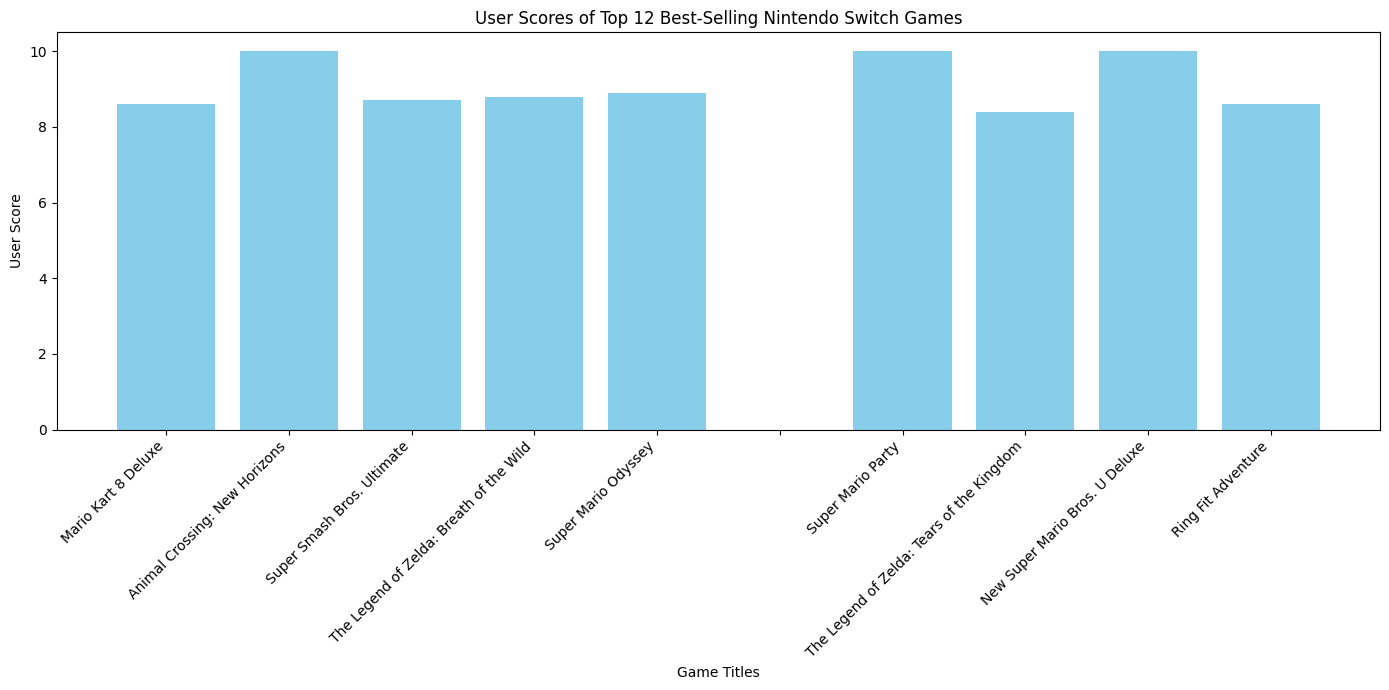

In [12]:
# Ensure user_score is numeric and fill any non-numeric values with 0
reviews_df['user_score'] = pd.to_numeric(reviews_df['user_score'], errors='coerce').fillna(0)

# Filter out rows with no title
reviews_df_filtered = reviews_df[reviews_df['title'].notna()]

# Plot the bar graph
plt.figure(figsize=(14, 7))
plt.bar(reviews_df_filtered['title'], reviews_df_filtered['user_score'], color='skyblue')
plt.xlabel('Game Titles')
plt.ylabel('User Score')
plt.title('User Scores of Top 12 Best-Selling Nintendo Switch Games')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()


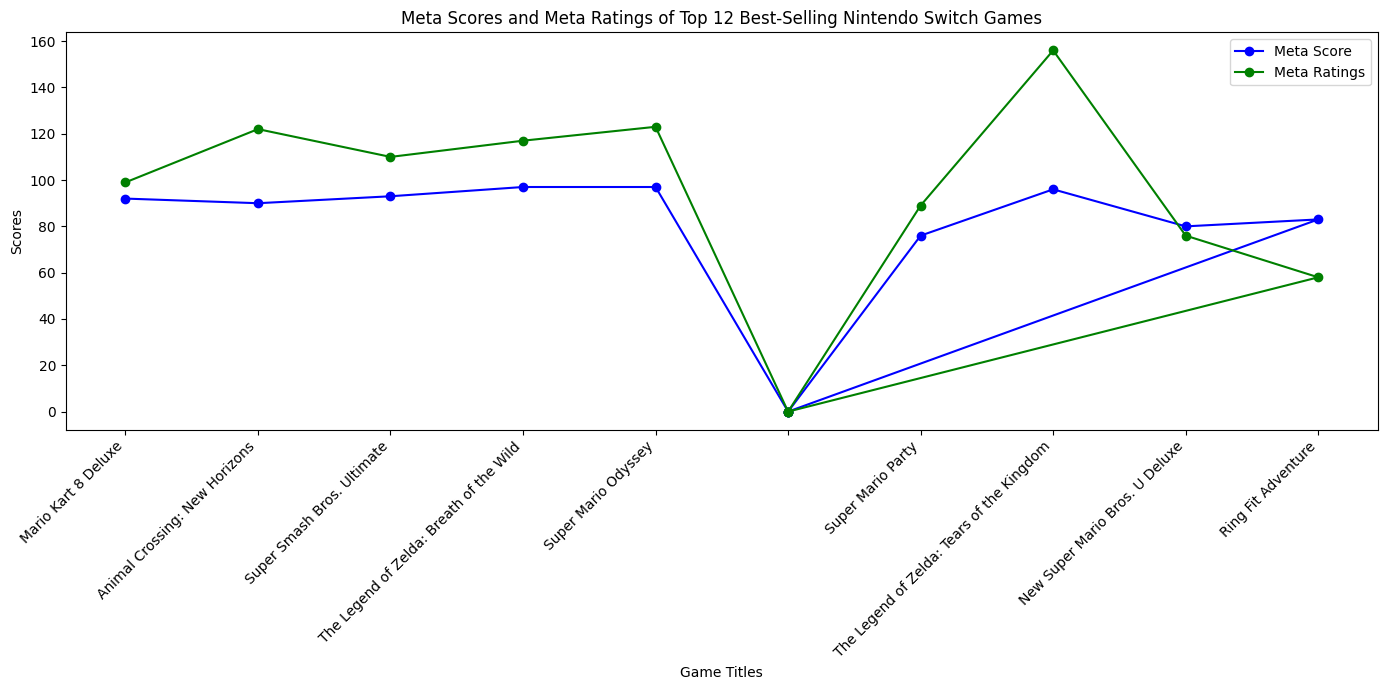

In [13]:
# Ensure meta_score and meta_ratings are numeric and fill any non-numeric values with 0
reviews_df['meta_score'] = pd.to_numeric(reviews_df['meta_score'], errors='coerce').fillna(0)
reviews_df['meta_ratings'] = pd.to_numeric(reviews_df['meta_ratings'], errors='coerce').fillna(0)

# Filter out rows with no title
reviews_df_filtered = reviews_df[reviews_df['title'].notna()]

# Plot the line graph
plt.figure(figsize=(14, 7))
plt.plot(reviews_df_filtered['title'], reviews_df_filtered['meta_score'], marker='o', label='Meta Score', color='b')
plt.plot(reviews_df_filtered['title'], reviews_df_filtered['meta_ratings'], marker='o', label='Meta Ratings', color='g')
plt.xlabel('Game Titles')
plt.ylabel('Scores')
plt.title('Meta Scores and Meta Ratings of Top 12 Best-Selling Nintendo Switch Games')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


In [14]:
# Convert the list of dictionaries to a DataFrame
metacritic_df = pd.DataFrame(metacritic_results)

# Ensure 'user_ratings' and 'user_score' are numeric and drop rows with non-numeric values
metacritic_df['user_ratings'] = pd.to_numeric(metacritic_df['user_ratings'], errors='coerce')
metacritic_df['user_score'] = pd.to_numeric(metacritic_df['user_score'], errors='coerce')

# Filter out rows with missing values in 'user_ratings' and 'user_score'
filtered_metacritic_df = metacritic_df.dropna(subset=['user_ratings', 'user_score'])

filtered_metacritic_df.head()

from sklearn.linear_model import LinearRegression


# Reshape the data
X = filtered_metacritic_df['user_ratings'].values.reshape(-1, 1)
y = filtered_metacritic_df['user_score'].values

# Create the model and fit it
model = LinearRegression()
model.fit(X, y)

# Get the slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_



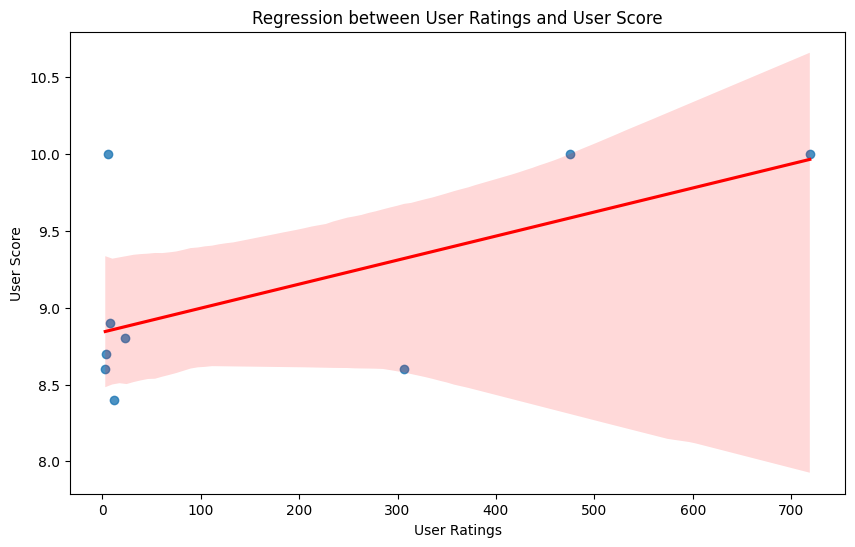

In [15]:
# Create scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='user_ratings', y='user_score', data=filtered_metacritic_df, line_kws={'color': 'red'})

plt.xlabel('User Ratings')
plt.ylabel('User Score')
plt.title('Regression between User Ratings and User Score')
plt.show()


Mean Squared Error: 1.1777777777777754
R^2 Score: 0.0


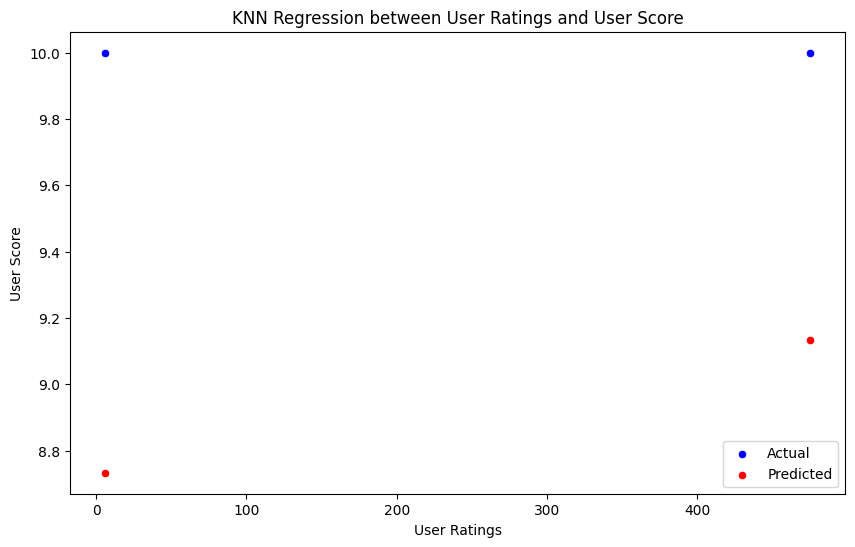

In [16]:
# Preprocessing and cleaning up the data
metacritic_df['user_ratings'] = pd.to_numeric(metacritic_df['user_ratings'], errors='coerce')
metacritic_df['user_score'] = pd.to_numeric(metacritic_df['user_score'], errors='coerce')

# Filter out rows with missing values in 'user_ratings' and 'user_score'
filtered_metacritic_df = metacritic_df.dropna(subset=['user_ratings', 'user_score'])

# Prepare data for KNN
X = filtered_metacritic_df[['user_ratings']]
y = filtered_metacritic_df['user_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the KNN model
knn = KNeighborsRegressor(n_neighbors=3)  # You can choose the number of neighbors
knn.fit(X_train, y_train)

# Predict on the test data
y_pred = knn.predict(X_test)

# Calculate the mean squared error and r2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot the scatter plot with KNN regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test['user_ratings'], y=y_test, color='blue', label='Actual')
sns.scatterplot(x=X_test['user_ratings'], y=y_pred, color='red', label='Predicted')
plt.xlabel('User Ratings')
plt.ylabel('User Score')
plt.title('KNN Regression between User Ratings and User Score')
plt.legend()
plt.show()